In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as trns
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, random_split

import os
import sys
import random
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

from PIL import Image
from IPython import display
from tqdm import tqdm, trange
from scipy.signal import find_peaks, resample
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix


## cut to beat sequence

In [11]:
train_beats, train_label = [], []
test_beats, test_label = [], []
s_beats, s_label = [], []
e_beats, e_label = [], []

pbar = trange(45)

def to_sequence(target=0,len_thres=128,peak_thres=0.5):
    heart = np.loadtxt('exercise_ECGID/%d.txt'%target, delimiter=' ')
    peaks, height = find_peaks(heart, height=peak_thres)
    data = []
    for k in range(len(peaks)-1):
        if peaks[k+1]-peaks[k] > len_thres:
            data.append(heart[peaks[k]:peaks[k+1]])
    return data

for i in pbar:
    stationary = to_sequence(target=2*i+1)    
    exercise = to_sequence(target=2*i+2)
    s_train, s_test = train_test_split(stationary, test_size=0.3)
    e_train, e_test = train_test_split(exercise, test_size=0.3)
    
    train_beats += s_train+e_train
    test_beats += s_test+e_test
    
    s_beats += s_train+s_test
    e_beats += e_train+e_test
    
    train_label += [i for t in range(len(s_train)+len(e_train))]
    test_label += [i for t in range(len(s_test)+len(e_test))]
    
    s_label += [i for t in range(len(s_train)+len(s_test))]
    e_label += [i for t in range(len(e_train)+len(e_test))]
    
    pbar.set_description("beats: %d"%(len(train_beats)+len(test_beats)))
    
print("train_beats %d"%len(train_beats))
print("train_label %d"%len(train_label))
print("test_beats %d"%len(test_beats))
print("test_label %d"%len(test_label))
    
print("station_beats %d"%len(s_beats))
print("station_label %d"%len(s_label))
print("exercise_beats %d"%len(e_beats))
print("exercise_label %d"%len(e_label))

beats: 24586: 100%|██████████| 45/45 [00:02<00:00, 15.91it/s]

train_beats 17170
train_label 17170
test_beats 7416
test_label 7416
station_beats 16965
station_label 16965
exercise_beats 7621
exercise_label 7621


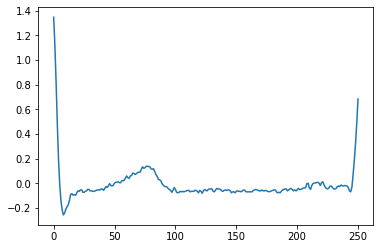

In [3]:
plt.plot(random.choice(train_beats))
plt.show()

## dataset & dataloader

In [4]:
class BeatDataset(Dataset):
    def __init__(self,datas,labels):
        self.beats = datas
        self.labels = labels
            
    def __getitem__(self,index):
        beat = self.beats[index]
        
        # (-1,1)
        # beat = (beat-np.min(beat))/(np.max(beat)-np.min(beat))*2-1
        
        # standardrize
        beat = (beat - np.mean(beat)) / np.std(beat)
        
        beat = torch.Tensor(np.expand_dims(beat,axis=1))
        downsample = resample(beat,128)
        downsample = np.squeeze(downsample,axis=1)
        label = self.labels[index]
            
        return beat, label, downsample
    
    def __len__(self):
        return len(self.labels)

In [12]:
batch_size = 16
split_ratio = 0.8

train_set = BeatDataset(train_beats,train_label)
test_set = BeatDataset(test_beats,test_label)
rest_set = BeatDataset(s_beats,s_label)
exercise_set = BeatDataset(e_beats,e_label)

# rnn_utils.pack_sequence
def collate_fn(batch):
    data = [item[0] for item in batch]
    downsample = torch.Tensor([item[2] for item in batch])
    lengths = torch.Tensor([len(item[0]) for item in batch])
    label = torch.Tensor([item[1] for item in batch])
    data = rnn_utils.pad_sequence(data, batch_first=False, padding_value=0)
    data = rnn_utils.pack_padded_sequence(data,lengths,batch_first=False, enforce_sorted=False)
    return data, label, downsample

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

rest_loader = DataLoader(rest_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
exercise_loader = DataLoader(exercise_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

# for bs, ls, ds, lens in train_loader:
#     print(ds.shape)
# #     test = torch.squeeze(test)
# #     print(test.data.shape)
#     break

## Auto Encoder

In [6]:
class AEmodule(nn.Module):
    def __init__(self):
        super(AEmodule, self).__init__()
        self.input_feature_dim=1
        self.hidden_feature_dim=128
        self.hidden_layer_num=1
        self.latent_size = 32
        self.de_hidden_layer_num = 1
        self.de_hidden_feature_dim = 1
        #---------------------------------------------------------------------------------------
        self.en_lstm = nn.LSTM(self.input_feature_dim, self.hidden_feature_dim, self.hidden_layer_num)
        self.en_linear1 = nn.Linear(self.hidden_feature_dim, self.latent_size)
        #---------------------------------------------------------------------------------------
        self.de_linear1 = nn.Sequential(nn.Linear(self.latent_size, 128),
                                       nn.ReLU())
        self.de_lstm = nn.LSTM(128, self.de_hidden_feature_dim, self.de_hidden_layer_num)
        #---------------------------------------------------------------------------------------
        self.de_linear2 = nn.Sequential(nn.Linear(self.latent_size, 64),
                                       nn.ReLU())
        self.de_linear3 = nn.Sequential(nn.Linear(64, 128))
    
    def encoder_lstm(self,x):
        x,(hn,cn)= self.en_lstm(x)
        hn = torch.squeeze(hn)
        x = self.en_linear1(hn)
        return x,(hn,cn)
    
    def decoder(self,x):
        x = self.de_linear2(x)
        x = self.de_linear3(x)
        return x
    
    def decoder_lstm(self,x, h, lens_unpacked):
        x = self.de_linear1(x)
        x = torch.unsqueeze(x,1)
        x = torch.unsqueeze(x,1)
        # (batch, 1, 1, 256)
        beats = torch.zeros(len(lens_unpacked), max(lens_unpacked), 1).to(x.device)
        for b ,seq_len in enumerate(lens_unpacked):
            # h0=t.randn(self.hidden_layer_num,self.batch_size,self.hidden_feature_dim)
            h = torch.randn(self.de_hidden_layer_num,1,self.de_hidden_feature_dim).to(x.device)
            c = torch.randn(self.de_hidden_layer_num,1,self.de_hidden_feature_dim).to(x.device)
            for i in range(seq_len):
                o,(h,c) = self.de_lstm(x[b],(h,c))
                beats[b,i] = o
        return beats
    
    def forward(self,x,lens_unpacked):
        x, h = self.encoder_lstm(x)
        #  x = self.decoder_lstm(x, h, lens_unpacked)
        x = self.decoder(x)
        return x 

## train

loss: 0.012313: 100%|██████████| 50/50 [10:05<00:00, 12.12s/it]


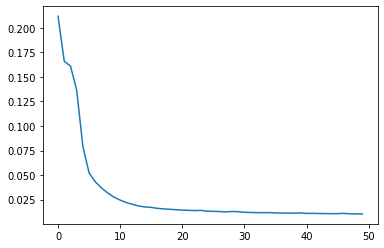

AEmodule(
  (en_lstm): LSTM(1, 128)
  (en_linear1): Linear(in_features=128, out_features=32, bias=True)
  (de_linear1): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
  )
  (de_lstm): LSTM(128, 1)
  (de_linear2): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
  )
  (de_linear3): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
  )
)

In [7]:
learning_rate = 0.001
ae = AEmodule()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ae.to(device)
optimizer = optim.Adam(ae.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

loss_log = []
losses = []
epoch = 50
t = trange(epoch)

for e in t:
    for bs, ls, ds in train_loader:
        bs = bs.to(device)
        ds = ds.to(device)
        
        seq_unpacked, lens_unpacked = rnn_utils.pad_packed_sequence(bs, batch_first=True)
        
        optimizer.zero_grad()
        x = ae.forward(bs,lens_unpacked)
        loss = criterion(x, ds)
        loss.backward()
        optimizer.step()
        
        t.set_description("loss: %f"%loss.item())
        losses.append(loss.item())
        
    loss_log.append(np.mean(losses))
    losses = []
    
plt.plot(loss_log)
plt.show()
ae.eval()

## reconstruct test

--------------------------------------------
id: 25


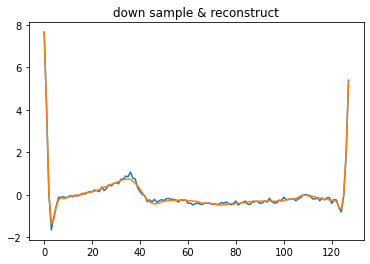

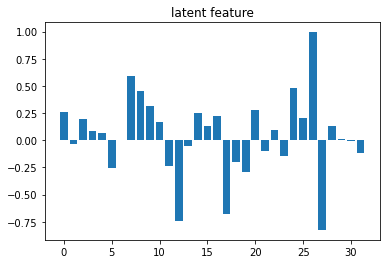

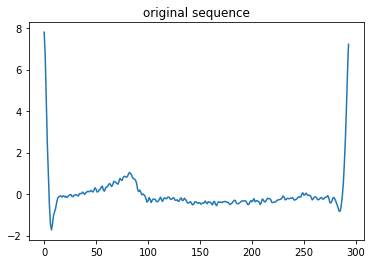

In [8]:
for bs, ls, ds in test_loader:
    bs = bs.to(device)
    seq_unpacked, lens_unpacked = rnn_utils.pad_packed_sequence(bs, batch_first=True)
    
    l, h = ae.encoder_lstm(bs)
    x = ae.decoder(l)
    
    x = x.cpu().detach()
    bs = bs.cpu()
    l = l.cpu().detach()
    seq_unpacked = seq_unpacked.cpu()
    lens_unpacked = lens_unpacked.cpu()

    for i in range(1):
        print('--------------------------------------------')
        print("id: %d"%ls[i])
        
        plt.title("down sample & reconstruct")
        plt.plot(ds[i])
        plt.plot(x[i])
        plt.show()
        
        plt.title("latent feature")
        plt.bar(np.arange(len(l[i])), l[i])
        plt.show()
        
        plt.title("original sequence")
        plt.plot(seq_unpacked[i][:lens_unpacked[i]])
        plt.show()
    break

## generate latent code

In [13]:
def to_latent(dataloader):
    latent = []
    label = []
    t_loader = tqdm(dataloader)
    t_loader.set_description("generate latent")
    for bs, ls, ds in t_loader:
        bs = bs.to(device)    
        l, h = ae.encoder_lstm(bs)
        l = l.cpu().detach().numpy()
        ls = ls.numpy()
        latent.append(l)
        label.append(ls)
    latent = np.concatenate(latent)
    label = np.concatenate(label)
    return latent, label

train_latent, train_label = to_latent(train_loader)
test_latent, test_label = to_latent(test_loader)
print("train: ", train_latent.shape[0])
print("test: ", test_latent.shape[0])

rest_latent, rest_label = to_latent(rest_loader)
exercise_latent, exercise_label = to_latent(exercise_loader)
print("rest: ", rest_latent.shape[0])
print("exercise: ", exercise_latent.shape[0])

generate latent:   2%|▏         | 20/1061 [00:00<00:05, 193.63it/s]

train:  17170
test:  7416


generate latent: 100%|██████████| 477/477 [00:01<00:00, 244.97it/s]

rest:  16965
exercise:  7621


## KNN

accuracy:  0.9881337648327939


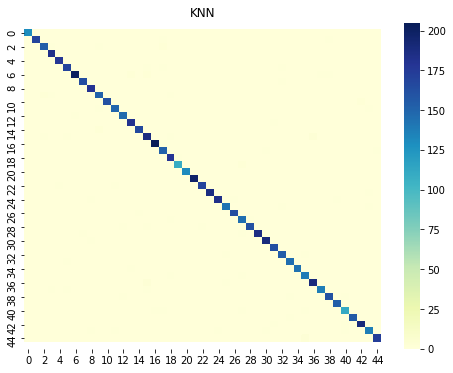

In [10]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(train_latent, train_label)

pred = neigh.predict(test_latent)
cf_mat = confusion_matrix(test_label,pred)

accu = np.where(test_label==pred)
print("accuracy: ",accu[0].shape[0]/test_label.shape[0])

plt.figure(figsize=(8,6))
plt.title("KNN")

# sn.heatmap(cf_mat, annot=True, fmt="d", cmap="YlGnBu")
sn.heatmap(cf_mat, cmap="YlGnBu")

b, t = plt.ylim()
b += 1
t -= 1
plt.ylim(b, t)
plt.show()


accuracy:  0.16323317149980318


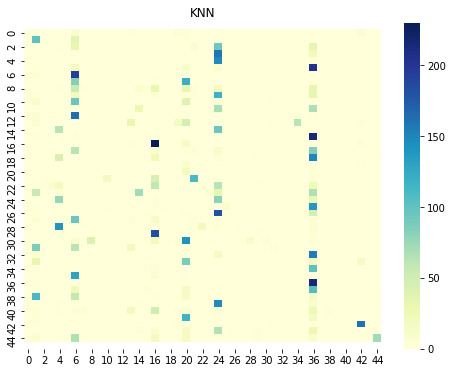

In [15]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(rest_latent, rest_label)

pred = neigh.predict(exercise_latent)
cf_mat = confusion_matrix(exercise_label,pred)

accu = np.where(exercise_label==pred)
print("accuracy: ",accu[0].shape[0]/exercise_label.shape[0])

plt.figure(figsize=(8,6))
plt.title("KNN")

# sn.heatmap(cf_mat, annot=True, fmt="d", cmap="YlGnBu")
sn.heatmap(cf_mat, cmap="YlGnBu")

b, t = plt.ylim()
b += 1
t -= 1
plt.ylim(b, t)
plt.show()